In [1]:
import os
import json
import glob
import datetime
import pandas as pd

from utils.utils import create_dir, get_different_between_two_dates, get_seconds_from_date, df_siamese_to_single
from utils.utils import save_data_backup_with_pairs, load_data_backup_with_pairs
from utils.loaders import get_wcs_dataset, get_wellington_dataset, get_caltech_dataset, get_serengeti_dataset

from tqdm import tqdm
from pathlib import Path
tqdm.pandas()

pd.options.mode.chained_assignment = None 
seed = 41

NAME_CONFIG = 'caltech'

MAPPER = json.load(open('/home/luiz/experiments/.whitelist/.scripts/utils/map.json'))
CONFIG = MAPPER[NAME_CONFIG]
IMAGE_DIR = CONFIG['images_path']

whitelist_filter_map = {}
# whitelist_filter_map = {
#     'path': '/home/luiz/experiments/.whitelist/datasets/ufam/cct_train_empty.csv',
#     'prefix': 'cct_images/',
#     'type': 'train',
# }

def check_exists(img):
    if Path(CONFIG['images_path'] + img).exists():
        return img
    else:
        return False

def get_random_df(df):
    return df.sample(len(df), random_state=seed).reset_index(drop=1)

def filter_images_by_other_whitelist(df, whitelist_path, prefix=""):
    df_whitelist = pd.read_csv(whitelist_path)
    if prefix:
        df_whitelist['file_name'] = df_whitelist.file_name.map(lambda a: prefix+a)
    images = df_whitelist.file_name.unique()
    return df[df['file_name'].isin(images)]


#### 2. organize images by time

In [27]:
print("load dataset", NAME_CONFIG)

data_loader_mapping = {
    'caltech': get_caltech_dataset,
    'wellington': get_wellington_dataset,
    'serengeti': get_serengeti_dataset,
    'wcs': get_wcs_dataset
}
dataset = data_loader_mapping[NAME_CONFIG](CONFIG)
dataset = dataset.dropna()
dataset.sample(4)

if whitelist_filter_map:
    dataset = filter_images_by_other_whitelist(dataset, whitelist_filter_map['path'], whitelist_filter_map['prefix'])

dataset.category.value_counts()

load dataset caltech


0    125745
1    119372
Name: category, dtype: int64

#### 3. get image background

In [28]:
print("load image time for each image")

file_names_images = glob.glob(f"{IMAGE_DIR}/{CONFIG['images_filenames_glob_*']}")
file_names_images = [file.replace(IMAGE_DIR, '') for file in file_names_images]

# dataset = dataset[dataset['file_name'].isin(file_names_masks)]
dataset = dataset[dataset['file_name'].isin(file_names_images)]

dataset['seconds'] = dataset.datetime.progress_apply(lambda a: get_seconds_from_date(a))
dataset.category.value_counts()

load image time for each image


100%|██████████| 245117/245117 [00:05<00:00, 48197.76it/s]


0    125745
1    119372
Name: category, dtype: int64

In [31]:
print("load pairs")

def find_pair(time, df_empty, days_limit=7, hours_limit=60*60*60*2):
    series = df_empty.datetime - time
    df_days = pd.DataFrame({ 'days': series.dt.days.abs(), 'seconds': df_empty.seconds })
    df_days = df_days[df_days.days < days_limit]
    if len(df_days) > 0:
        df_days['diferences'] = abs(df_days['seconds'] - get_seconds_from_date(time))
        df_days = df_days[
            (df_days.diferences > 0) &
            (df_days.diferences < hours_limit)
            ].sort_values(['diferences'])
        if len(df_days.index) > 0:
            index = df_days.index[0]
            return df_empty.file_name.values[index]

def get_df_with_pairs():
    dfs = []
    locations = dataset.location.unique()
    for location in tqdm(locations):
        df_day_time = dataset[dataset['location'] == location]
        df_empty = df_day_time[df_day_time['category'] == 0].reset_index(drop=1)
        if len(df_empty) > 0:
            df_day_time['file_name_y'] = df_day_time.index.map(lambda a: find_pair(df_day_time.datetime[a], df_empty))
            dfs.append(df_day_time)
        else:
            continue

    data = pd.concat(dfs)
    return get_random_df(data).dropna()

# data = get_df_with_pairs()
# data = data.dropna()
# data = data.rename(columns={
#     "file_name": "file_name_x",
#     "location": "location_x",
#     "day_time": "day_time_y",
# })
# save_data_backup_with_pairs(data, CONFIG)
data = load_data_backup_with_pairs(CONFIG)

print('images size balanced:', len(data))
print('class 0', len(data[data['category'] == 0]))
print('class 1', len(data[data['category'] == 1]))

data['camera'] = data.location_x.map(lambda a: ''.join(str(a).split('_')[:2]))
data.head()

load pairs
images size balanced: 213092
class 0 125663
class 1 87429


file_name_x  location_x day_time_y  \
0  cct_images/58a8a31c-23d2-11e8-a6a3-ec086b02610...          96    morning   
1  cct_images/5962937f-23d2-11e8-a6a3-ec086b02610...          70      night   
2  cct_images/59c80629-23d2-11e8-a6a3-ec086b02610...          23    morning   
3  cct_images/59e77c89-23d2-11e8-a6a3-ec086b02610...          33      night   
4  cct_images/5a1fe852-23d2-11e8-a6a3-ec086b02610...          33      night   

              datetime  category  seconds  \
0  2014-05-26 13:56:23         0    50183   
1  2013-12-21 01:46:54         1     6414   
2  2014-07-28 09:00:00         0    32400   
3  2012-05-02 04:16:03         1    15363   
4  2011-05-12 02:05:55         1     7555   

                                         file_name_y camera  
0  cct_images/58cb12a6-23d2-11e8-a6a3-ec086b02610...     96  
1  cct_images/59518e5d-23d2-11e8-a6a3-ec086b02610...     70  
2  cct_images/597b4a0f-23d2-11e8-a6a3-ec086b02610...     23  
3  cct_images/596a4f4b-23d2-11e8-a6a3-ec086b02610...     33  
4  cct_images/5a02fbcd-23d2-11e8-a6a3-ec086b02610...     33

In [33]:
proportions = {'test': 0.33, 'train': 0.33, 'val': 0.33}
print("create subsets", proportions)
idx, all_cameras = 0, data.camera.unique()

def get_subset_instances_by_proportion(subset, idx, num_max):
    while (len(subset) < num_max and idx < len(all_cameras)):
        camera = all_cameras[idx]
        subset = pd.concat([
            subset,
            data[data.camera == camera]
        ])
        idx += 1
    return subset, idx

def split_subsets(type, idx, is_balanced=False):
    print('processing', type)
    subset = pd.DataFrame()
    num_max = len(data)*proportions[type]
    subset, idx = get_subset_instances_by_proportion(subset, idx, num_max)
    if is_balanced:
        min_size = min(subset.category.value_counts())
        subset = pd.concat([
            subset[subset.category == 1][:min_size],
            subset[subset.category == 0][:min_size]
        ])
        subset, idx = get_subset_instances_by_proportion(subset, idx, num_max)
    print(f'{round(len(subset)/len(data)*100, 2)}% \n{subset.category.value_counts()}')
    return subset, idx

if not whitelist_filter_map:
    train, idx = split_subsets('train', idx)
    test, idx = split_subsets('test', idx)
    val, idx = split_subsets('val', idx)

create subsets {'test': 0.33, 'train': 0.33, 'val': 0.33}
processing train
35.71% 
0    64331
1    11766
Name: category, dtype: int64
processing test
37.83% 
0    47987
1    32626
Name: category, dtype: int64
processing val
26.46% 
1    43037
0    13345
Name: category, dtype: int64


#### 4. Saving data..

In [2]:
def save_siamese(subset, type, subfolder=''):
    df_time = subset[['file_name_x', 'file_name_y', 'location_x', 'day_time_y', 'category', 'datetime']]
    df_time = df_time.rename(columns={"location_x": "location","day_time_y": "day_time"})
    create_dir(CONFIG['path_target_time_siamese'] + subfolder)
    path = CONFIG['path_target_time_siamese'] + subfolder + type + '.csv'
    df_time.to_csv(path, index=False)
    df_siamese_to_single(df_time).to_csv(path.replace('siamese', 'no-siamese'), index=False)


def load_siamese(type, subfolder=''):
    return pd.read_csv(CONFIG['path_target_time_siamese'] + subfolder + type + '.csv')

def load_no_siamese(type, subfolder=''):
    return pd.read_csv(CONFIG['path_target_time'] + subfolder + type + '.csv')

In [35]:
print("saving subsets")
if whitelist_filter_map:
    save_siamese(data, whitelist_filter_map['type'], 'ufam/')
else:
    save_siamese(train, 'train')
    save_siamese(val, 'val')
    save_siamese(test, 'test')
    save_siamese(pd.concat([train, val, test]), 'all')

saving subsets


#### 4.1 Saving small data..

In [36]:
def process_different_between_two_dates(subset):
    subset = subset.merge(dataset, left_on='file_name_y', right_on='file_name')
    subset['datetime_x'] = subset.datetime_x.map(lambda a: pd.to_datetime(a))
    subset['diff'] = subset.index.map(lambda a: get_different_between_two_dates(subset['datetime_x'][a], subset['datetime_y'][a])/60)
    subset = subset.rename(columns={
        "category_x": "category",
        "location_x": "location",
        "datetime_x": "datetime",
        "day_time_x": "day_time",
        })
    return subset.sort_values(['diff'])[[
        'file_name_x',
        'file_name_y',
        'location',
        'day_time',
        'category',
        'datetime'
        ]]

def transform_short_subset(subset, type, is_balanced, is_siamese):
    print('transforming subset small', type)
    if is_siamese:
        path = CONFIG['path_target_time_siamese'] + 'short/'
    else:
        path = CONFIG['path_target_time'] + 'short/'
    create_dir(path)
    subset = process_different_between_two_dates(subset)

    size = int(proportions[type] * TOTAL_SIZE_DATASET)//2
    if is_balanced:
        subset = pd.concat([
            subset[subset.category == 1][:size],
            subset[subset.category == 0][:size]
        ])
    else:
        subset = pd.concat([
            subset[subset.category == 1][:size],
            subset[subset.category == 0][:size + int(0.3*size)]
        ])
    subset = subset.sample(len(subset), random_state=seed)
    
    target_path = path + type + '.csv'
    print(subset.category.value_counts())

    subset.to_csv(target_path, index=False)
    df_siamese_to_single(subset).to_csv(target_path.replace('siamese', 'no-siamese'), index=False)

TOTAL_SIZE_DATASET = 50000
proportions = {'test': 0.2, 'train': 0.7, 'val': 0.1}

train = load_siamese('train')
val = load_siamese('val')
test = load_siamese('test')

transform_short_subset(train, 'train', True, True)
transform_short_subset(val, 'val', True, True)
transform_short_subset(test, 'test', False, True)

transforming subset small train
0    17500
1    11766
Name: category, dtype: int64
transforming subset small val
0    2500
1    2500
Name: category, dtype: int64
transforming subset small test
0    6500
1    5000
Name: category, dtype: int64


#### 5. View time variation

In [3]:
import statistics

def show_time_variation(subset):
    time = subset.merge(dataset, left_on='file_name_y', right_on='file_name')[['datetime_x', 'datetime_y']]
    time['datetime_x'] = time.datetime_x.map(lambda a: pd.to_datetime(a))
    series = []
    for i in time.index:
        minutes = get_different_between_two_dates(time['datetime_x'][i], time['datetime_y'][i])/60
        series.append(minutes)

    mean = round(statistics.mean(series), 2)
    median = round(statistics.median(series), 2)
    variance = round(statistics.variance(series), 2)
    stdev = round(statistics.stdev(series), 2)

    print("mean:", mean)
    print("median:", median)
    print("variance:", variance)
    print("stdev:", stdev, "\n")
    return series

for i in MAPPER.keys():
# for i in ['wcs']:
    CONFIG = MAPPER[i]
    IMAGE_DIR = CONFIG['images_path']

    data_loader_mapping = {
            'caltech': get_caltech_dataset,
            'wellington': get_wellington_dataset,
            'serengeti': get_serengeti_dataset,
            'wcs': get_wcs_dataset
    }
    dataset = data_loader_mapping[i](CONFIG)
    dataset = dataset.dropna()
    for subset_name in ['short/train', 'short/val', 'short/test']:
        print(i, subset_name)
        s = load_siamese(subset_name)
        print(s.category.value_counts())
        series = show_time_variation(s)

caltech short/train
0    17500
1    11766
Name: category, dtype: int64
mean: 37.06
median: 6.61
variance: 9421.71
stdev: 97.07 

caltech short/val
0    2500
1    2500
Name: category, dtype: int64
mean: 143.51
median: 37.65
variance: 57455.15
stdev: 239.7 

caltech short/test
0    6500
1    5000
Name: category, dtype: int64
mean: 85.31
median: 10.9
variance: 31935.92
stdev: 178.71 

serengeti short/train
0    105000
1    105000
Name: category, dtype: int64
mean: 9.7
median: 0.75
variance: 1092.91
stdev: 33.06 

serengeti short/val
1    15000
0    15000
Name: category, dtype: int64
mean: 33.05
median: 5.0
variance: 6367.25
stdev: 79.8 

serengeti short/test
0    39000
1    30000
Name: category, dtype: int64
mean: 15.63
median: 1.57
variance: 2131.33
stdev: 46.17 

wellington short/train
1    17500
0    11174
Name: category, dtype: int64
mean: 56.52
median: 17.0
variance: 11958.23
stdev: 109.35 

wellington short/val
0    2500
1    2500
Name: category, dtype: int64
mean: 136.13
median: 58

#### 6. View images

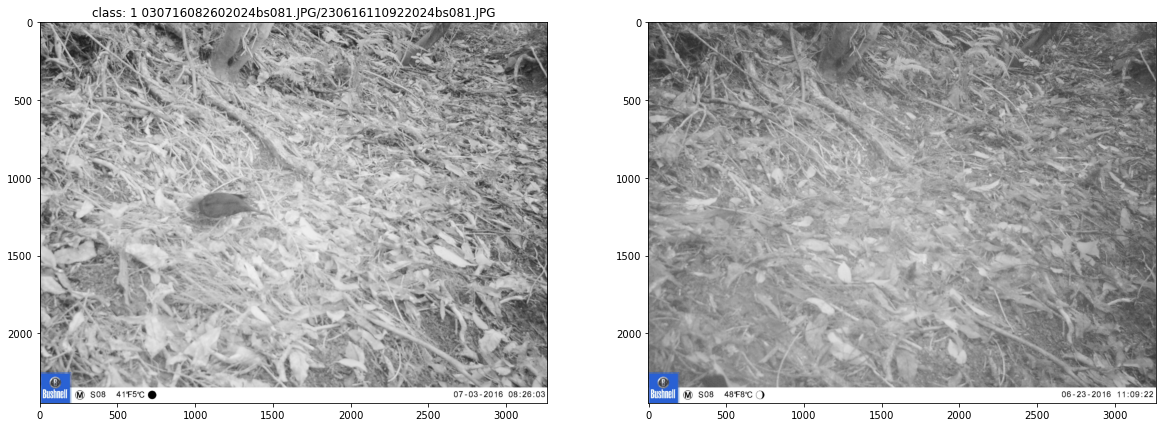

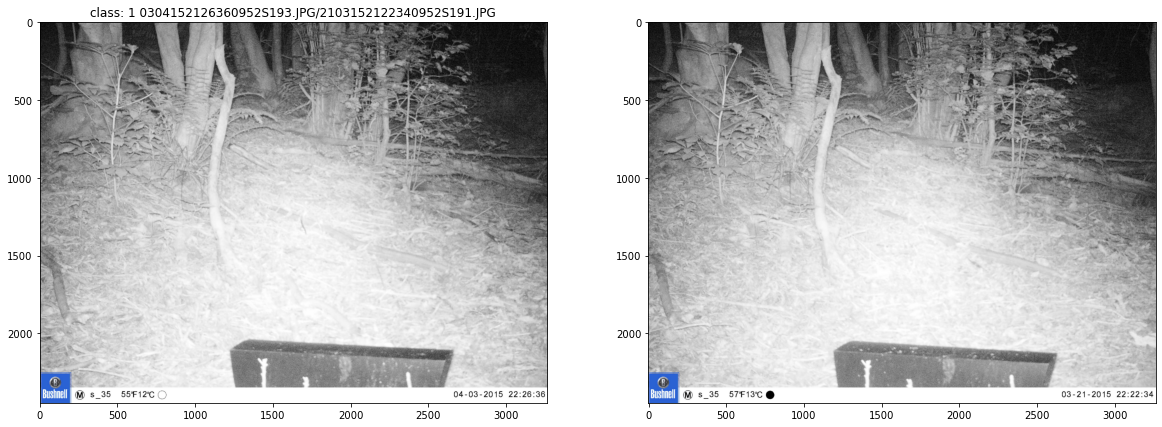

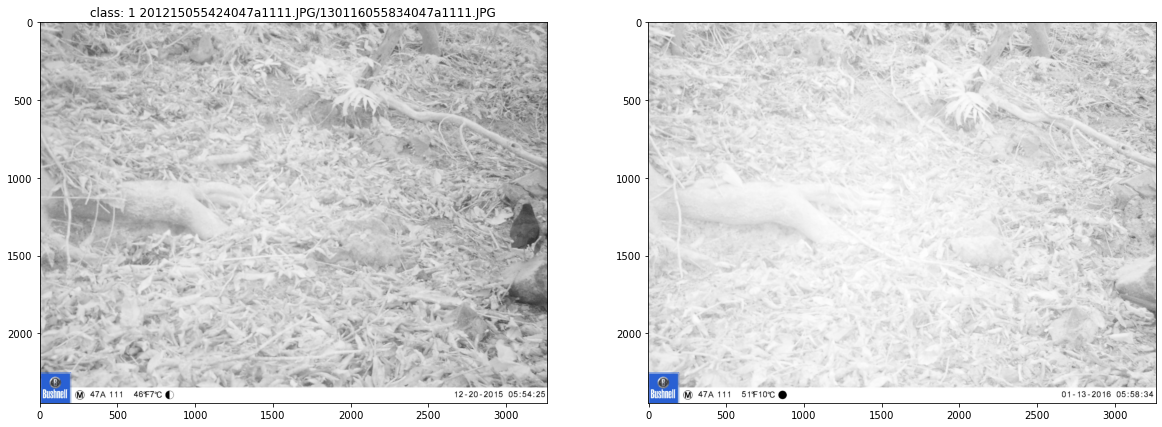

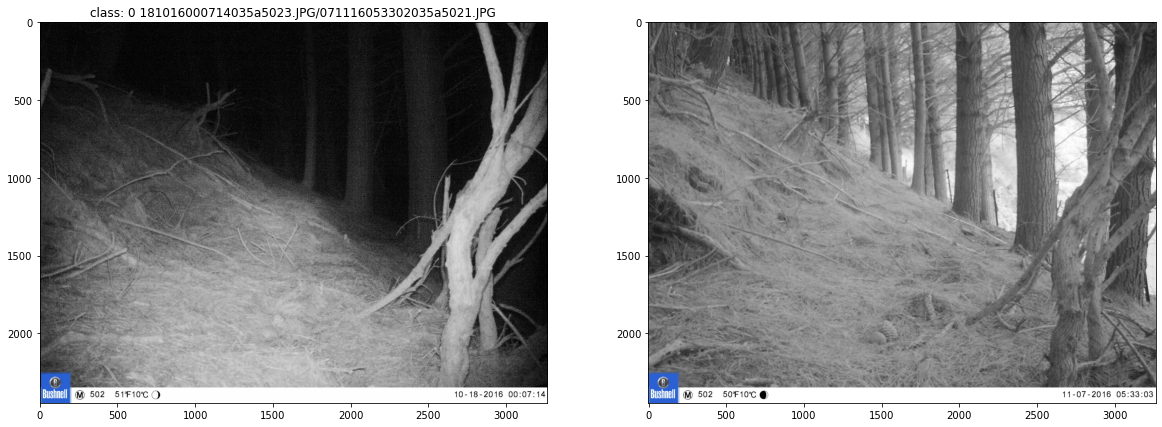

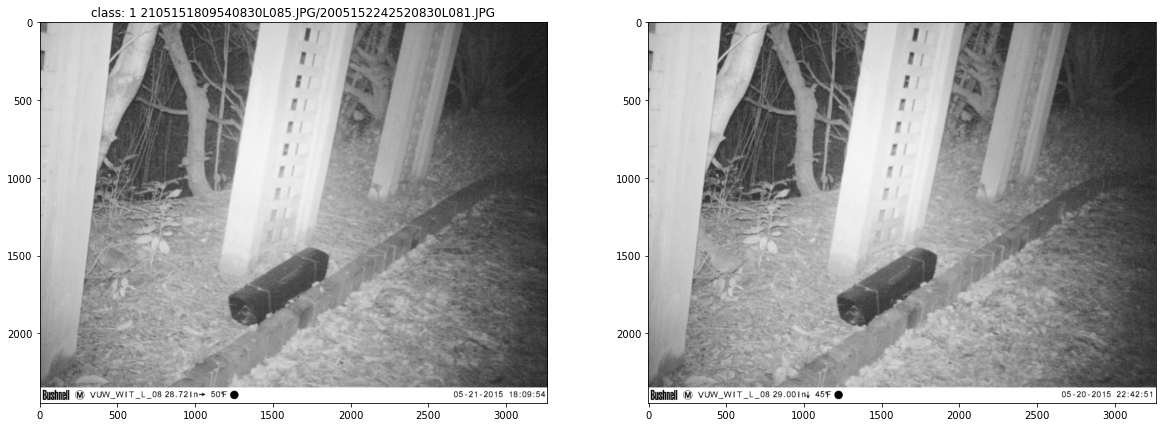

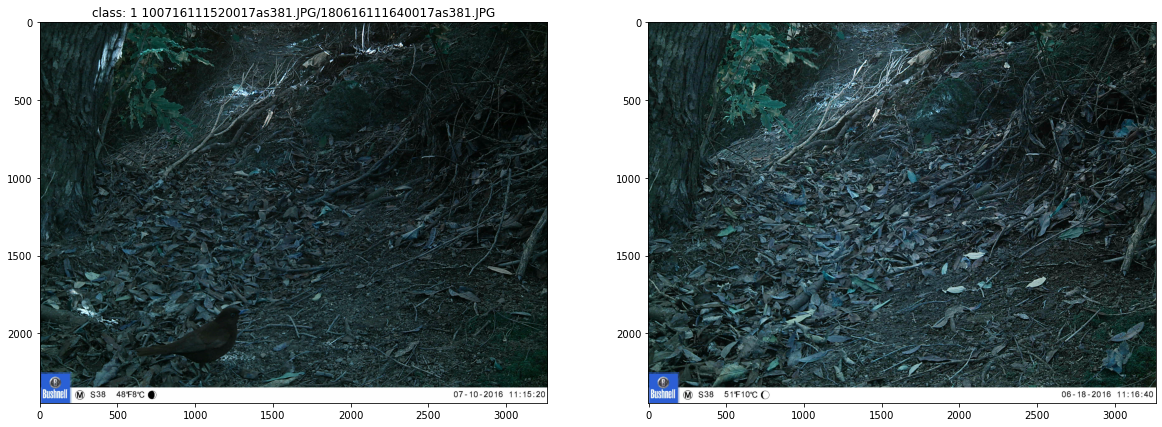

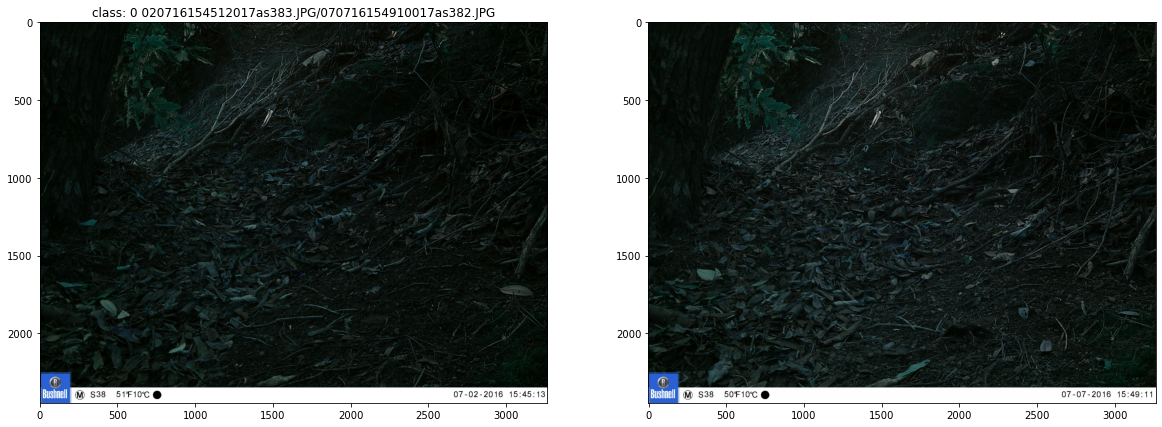

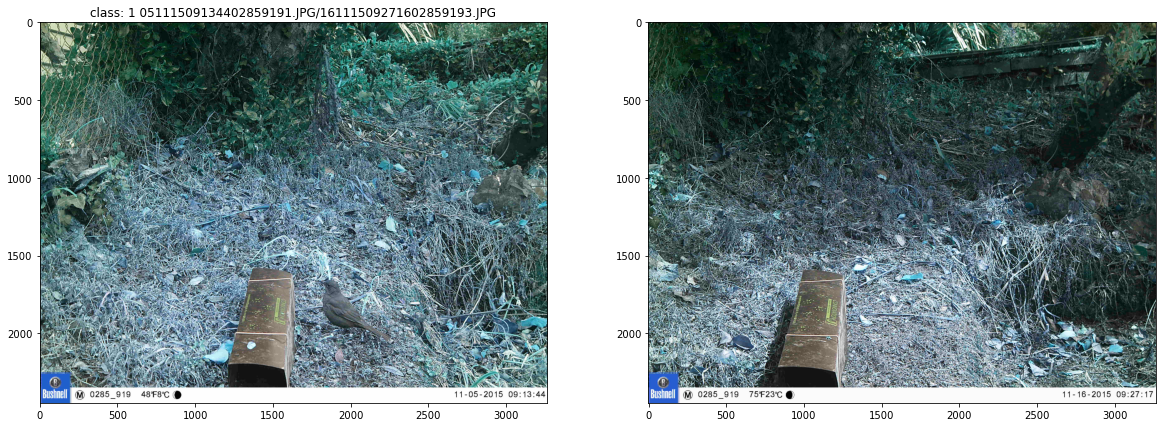

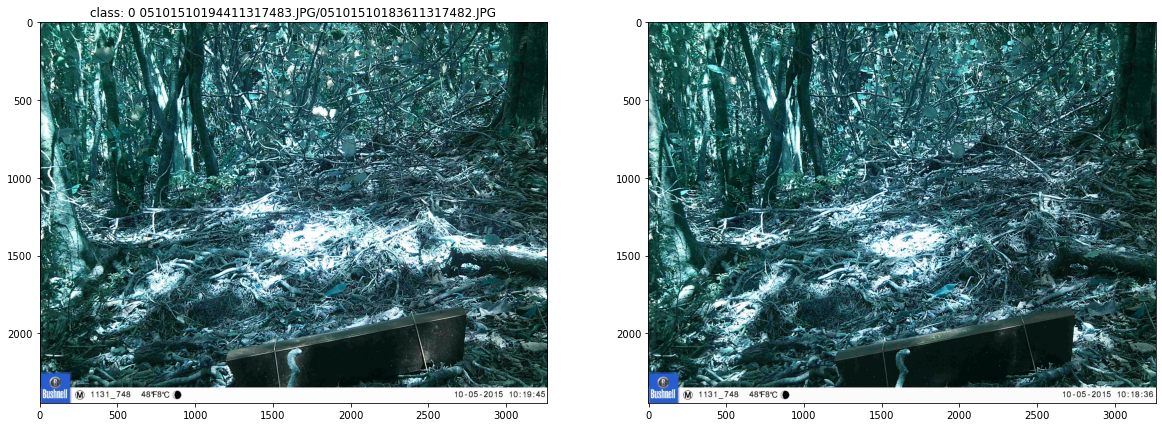

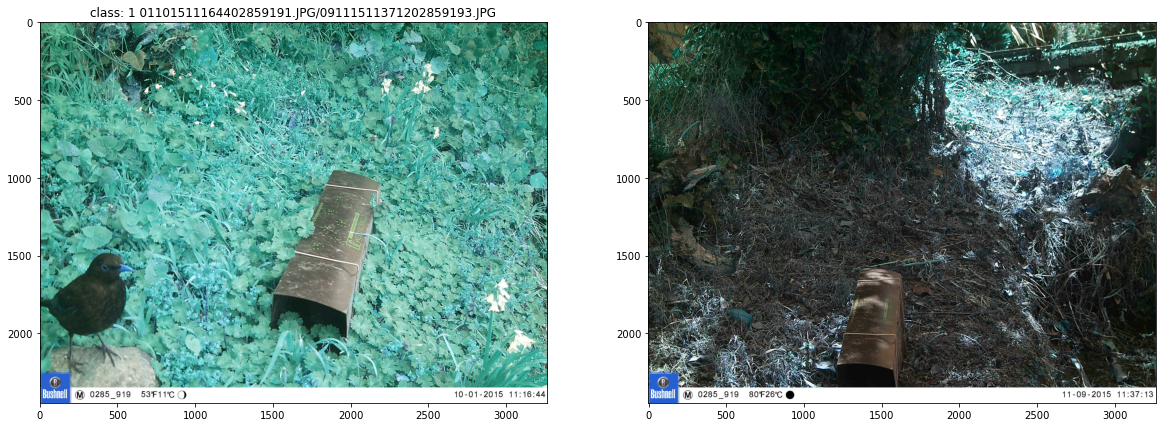

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def show_imgs(t):
    df = load_siamese(t)
    for i in df.sample(10).index:
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        img1 = np.array(Image.open(IMAGE_DIR + df['file_name_x'][i]))
        img2 = np.array(Image.open(IMAGE_DIR + df['file_name_y'][i]))

        ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB).astype(np.uint8))
        ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB).astype(np.uint8))
        ax[0].title.set_text(f"""class: {df['category'][i]} {df['file_name_x'][i]}/{df['file_name_y'][i]}""")
        
show_imgs('val')

#### 7. Data ploting

''

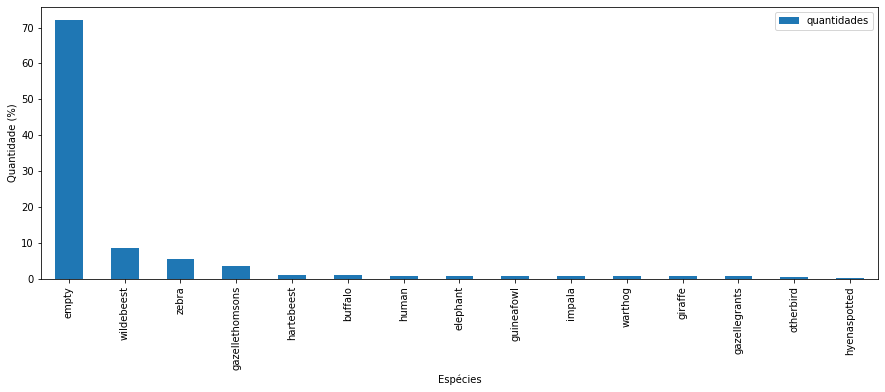

In [49]:
import matplotlib.pyplot as plt

metadata = get_annotations('../../../../../data/luiz/dataset/serengeti/SnapshotSerengeti_S1-11_v2.1.json')
df = pd.DataFrame(metadata['annotations'])

def search_categories(id):
    for i in metadata['categories']:
        if id == i['id']:
            return i['name']

df['season_num'] = df['season'].map(lambda a: int(a[-2:].replace('S', '')))
df_filter = df[df['season_num'] < 7]

animals = pd.DataFrame({
    'classes': df_filter.category_id.value_counts().index,
    'quantidades': df_filter.category_id.value_counts().values
})
animals.classes = animals.classes.map(lambda a: search_categories(a))
animals.quantidades = animals.quantidades.map(lambda a: a/animals.quantidades.sum() * 100)

samples = animals[:15]

fig = samples.plot(kind='bar', figsize=(15, 5))
fig.set_xlabel('Espécies')
fig.set_ylabel('Quantidade (%)')
fig.set_xticklabels(samples.classes)
''